In [1]:
from scipy.io import loadmat
import numpy as np
import pandas as pd
import matplotlib as plt

from keras.preprocessing.image import img_to_array
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense
from keras import backend as K
from PIL import Image

%matplotlib inline

In [2]:
#run this because mac doesn't work well otherwise
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

Here is the description for each data file provided - 

-cars_meta.mat:
  Contains a cell array of class names, one for each class.

-cars_train_annos.mat:
  Contains the variable 'annotations', which is a struct array of length
  num_images and where each element has the fields:
    bbox_x1: Min x-value of the bounding box, in pixels
    bbox_x2: Max x-value of the bounding box, in pixels
    bbox_y1: Min y-value of the bounding box, in pixels
    bbox_y2: Max y-value of the bounding box, in pixels
    class: Integral id of the class the image belongs to.
    fname: Filename of the image within the folder of images.

-cars_test_annos.mat:
  Same format as 'cars_train_annos.mat', except the class is not provided.

In [3]:
# load data files
cars_meta_file = loadmat('./devkit/cars_meta.mat')
cars_train_file = loadmat('./devkit/cars_train_annos.mat')
cars_test_file = loadmat('./devkit/cars_test_annos.mat')

In [44]:
# need to unnest the array
def unnest(x):
    if (isinstance(x, (str, int))):
        return x
    else:
        return x[0]

car_names_array = np.array([unnest(x) for x in cars_meta_file.get('class_names')[0]])
car_names_array.shape

(196,)

In [5]:
car_names_array[:10]

array(['AM General Hummer SUV 2000', 'Acura RL Sedan 2012',
       'Acura TL Sedan 2012', 'Acura TL Type-S 2008',
       'Acura TSX Sedan 2012', 'Acura Integra Type R 2001',
       'Acura ZDX Hatchback 2012',
       'Aston Martin V8 Vantage Convertible 2012',
       'Aston Martin V8 Vantage Coupe 2012',
       'Aston Martin Virage Convertible 2012'], dtype='<U54')

In [95]:
def two_d_unnest(x):
    return [unnest(item) for item in x]

def double_unnest_data(cars_file, cols):
    # looks like these training data are nested arrays too, need to un-nest them first
    nested_data = cars_file.get('annotations')[0]
    cars_data_unnested_once = np.array([two_d_unnest(x) for x in nested_data])
    cars_data = np.array([two_d_unnest(x) for x in cars_data_unnested_once])
    # convert to DataFrame
    data = pd.DataFrame(data=cars_data, columns=cols+['fname'])
    # convert the strings inside DataFrame to ints
    data[cols] = \
        data[cols].astype(int)
    return data
    
data_train = double_unnest_data(cars_train_file, ['bbox_x1','bbox_y1','bbox_x2','bbox_y2','class'])
print(data_train.shape)
data_train.head()

(8144, 6)


,bbox_x1,bbox_y1,bbox_x2,bbox_y2,class,fname
0,39,116,569,375,14,00001.jpg
1,36,116,868,587,3,00002.jpg
2,85,109,601,381,91,00003.jpg
3,621,393,1484,1096,134,00004.jpg
4,14,36,133,99,106,00005.jpg


In [53]:
print(f"Training data shape (samples x columns): {data_train.shape}")

Training data shape (samples x features): (8144, 6)


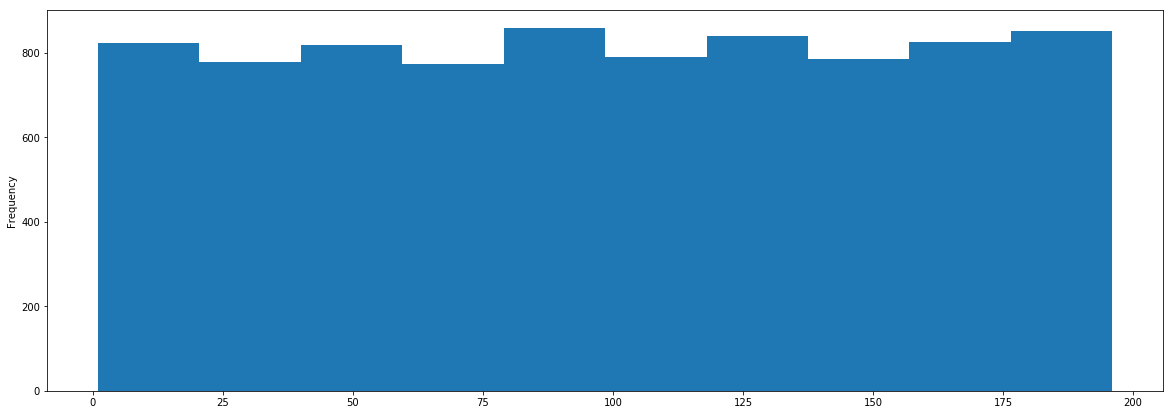

In [58]:
# check whether classes are skewed
plt.pyplot.figure(figsize=(20,7))
data_train['class'].plot.hist();

In [73]:
# preprocess test data as well
data_test = double_unnest_data(cars_test_file, ['bbox_x1','bbox_y1','bbox_x2','bbox_y2'])
data_test.head()

,bbox_x1,bbox_y1,bbox_x2,bbox_y2,fname
0,30,52,246,147,00001.jpg
1,100,19,576,203,00002.jpg
2,51,105,968,659,00003.jpg
3,67,84,581,407,00004.jpg
4,140,151,593,339,00005.jpg


In [74]:
print(f"Test data shape (samples x columns): {data_test.shape}")

Test data shape (samples x features): (8041, 5)


In [88]:
train_images = []
train_labels = []

for index, row in data_train.iterrows():
    image = load_image_custom(row)
    train_images.append(image)
    train_labels.append(row['class'])

In [96]:
def display_train_image(image_num):
    image = train_images[image_num]
    plt.pyplot.title(f'Example: {image_num}  Label: {train_labels[image_num-1]}')
    plt.pyplot.imshow(image, cmap=plt.pyplot.get_cmap('gray_r'))
    plt.pyplot.show()
    
def load_image_custom(image_row):
    image_path = './data/cars_train/' + image_row['fname']
    image = Image.open(image_path)
    image_bw = image.convert(mode='L') # convert image to grayscale
    crop_area = tuple((int(image_row['bbox_x1']),int(image_row['bbox_y1']),int(image_row['bbox_x2']),int(image_row['bbox_y2'])))
    cropped_image_bw = image_bw.crop(crop_area) # crop image to just the car area
    return cropped_image_bw

Chevrolet Express Van 2007


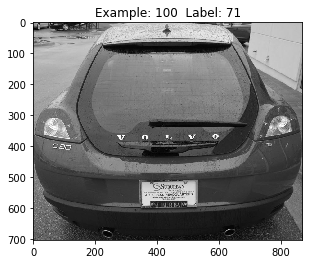

In [107]:
n=100
print(car_names_array[70])
# check randome image
display_train_image(n)

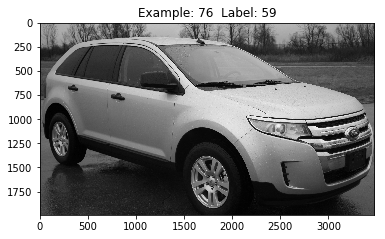

In [20]:
data_train.iloc[[123]]

,bbox_x1,bbox_y1,bbox_x2,bbox_y2,class,fname
123,14,88,271,178,53,00124.jpg


In [21]:
# check image size distribution, because I need to know what is the best size to resize all the test images to one size.
image_sizes = list()
for image in train_images:
    image_sizes.append(image.size)

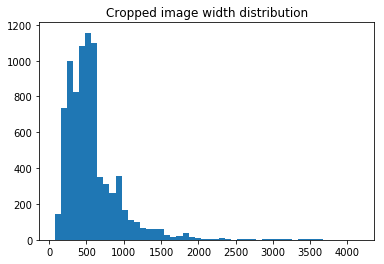

In [22]:
plt.pyplot.hist(x=[x[0] for x in image_sizes], bins=50)
plt.pyplot.title("Cropped image width distribution")
plt.pyplot.show()

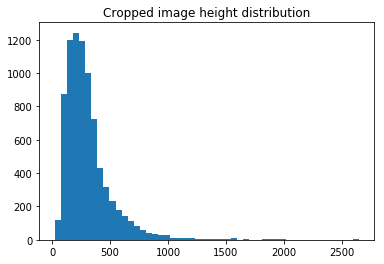

In [23]:
plt.pyplot.hist(x=[x[1] for x in image_sizes], bins=50)
plt.pyplot.title("Cropped image height distribution")
plt.pyplot.show()

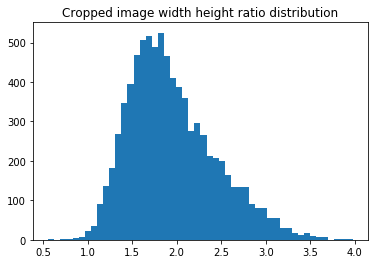

In [24]:
plt.pyplot.hist(x=[x[0]/x[1] for x in image_sizes], bins=50)
plt.pyplot.title("Cropped image width height ratio distribution")
plt.pyplot.show()

In [25]:
ratios = np.array([x[0]/x[1] for x in image_sizes])

In [26]:
print("Image size ratio median is ",np.median(ratios))
print("Image width median is ",np.median([x[0] for x in image_sizes]))
print("Image height median is ",np.median([x[1] for x in image_sizes]))

Image size ratio median is  1.8676060832954866
Image width median is  504.0
Image height median is  260.0


In [27]:
# will resize all images to smaller size just for the test run to be faster (504/4, 260/4) aka (126,65)
# process train images
unified_size = (126,65)
processed_train_images = list()

def process_images(image, images_array):
    image = image.resize(unified_size)
    images_array.append(img_to_array(image))

In [28]:
for image in train_images:
    process_images(image, processed_train_images)

In [29]:
processed_train_images_array = np.array(processed_train_images)

In [30]:
processed_train_images_array.shape

(8144, 65, 126, 1)

In [31]:
print("Input shape is")
processed_train_images_array[0].shape

Input shape is


(65, 126, 1)

In [32]:
from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical
encoder = LabelEncoder()
encoder.fit(train_labels)
encoded_Y = encoder.transform(train_labels)
categorical_train_labels = to_categorical(encoded_Y)

In [34]:
train_labels

['14',
 '3',
 '91',
 '134',
 '106',
 '123',
 '89',
 '96',
 '167',
 '58',
 '49',
 '186',
 '135',
 '85',
 '193',
 '172',
 '14',
 '73',
 '192',
 '57',
 '79',
 '36',
 '120',
 '170',
 '194',
 '134',
 '184',
 '86',
 '180',
 '194',
 '154',
 '139',
 '66',
 '133',
 '154',
 '104',
 '38',
 '97',
 '105',
 '142',
 '13',
 '191',
 '119',
 '38',
 '186',
 '25',
 '194',
 '177',
 '173',
 '42',
 '91',
 '148',
 '15',
 '97',
 '42',
 '53',
 '44',
 '65',
 '90',
 '124',
 '114',
 '190',
 '101',
 '187',
 '8',
 '17',
 '111',
 '122',
 '5',
 '29',
 '126',
 '94',
 '106',
 '106',
 '188',
 '59',
 '110',
 '43',
 '133',
 '111',
 '8',
 '192',
 '18',
 '116',
 '49',
 '145',
 '49',
 '170',
 '20',
 '114',
 '165',
 '138',
 '175',
 '112',
 '122',
 '104',
 '57',
 '51',
 '37',
 '71',
 '193',
 '105',
 '61',
 '74',
 '133',
 '162',
 '131',
 '88',
 '121',
 '180',
 '180',
 '137',
 '133',
 '71',
 '83',
 '110',
 '42',
 '177',
 '147',
 '161',
 '109',
 '28',
 '144',
 '53',
 '29',
 '66',
 '79',
 '13',
 '136',
 '143',
 '171',
 '89',
 '135'

In [44]:
#split test data
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(processed_train_images_array, categorical_train_labels, test_size=0.15, random_state=42)



In [45]:
processed_train_images_array.shape[1:]


(65, 126, 1)

In [46]:
model = Sequential()
model.add(Conv2D(32, (3, 3), input_shape=processed_train_images_array.shape[1:]))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dense(196, activation='softmax'))

model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

Instructions for updating:
Colocations handled automatically by placer.


In [47]:
model.fit(X_train, y_train,
          epochs=4,
          batch_size=32,
          validation_data=(X_test, y_test))

Instructions for updating:
Use tf.cast instead.
Train on 6922 samples, validate on 1222 samples
Epoch 1/4
6922/6922 [==============================] - 188s 27ms/step - loss: 16.0353 - acc: 0.0051 - val_loss: 16.0521 - val_acc: 0.0041
Epoch 2/4
6922/6922 [==============================] - 172s 25ms/step - loss: 16.0343 - acc: 0.0052 - val_loss: 16.0521 - val_acc: 0.0041
Epoch 3/4
6922/6922 [==============================] - 172s 25ms/step - loss: 16.0343 - acc: 0.0052 - val_loss: 16.0521 - val_acc: 0.0041
Epoch 4/4
6922/6922 [==============================] - 183s 26ms/step - loss: 16.0343 - acc: 0.0052 - val_loss: 16.0521 - val_acc: 0.0041


In [48]:
model.save_weights('first_try_model.h5')